## Gather necessary resources

In [1]:
!pip install -q tensorflow matplotlib scikit-learn seaborn kaggle

In [2]:
# Get tensorflow and check the version
import tensorflow as tf
print(tf.__version__)

2025-07-14 09:34:28.934776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752503668.953355 2020569 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752503668.959313 2020569 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752503668.973644 2020569 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752503668.973667 2020569 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752503668.973670 2020569 computation_placer.cc:177] computation placer alr

2.19.0


In [3]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [4]:
# Enable GPU memory growth, so TensorFlow only grabs what it needs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)

## Get the dataset and examine it
In order to train the model, we need a dataset of playing cards.  For this, we'll use a dataset available from Kaggle, which bills itself as "Your Machine Learning and Data Science Community".  The dataset is located on Kaggle at [Cards Image Dataset-Classification](https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification).  This page also includes information about how the data is structured, as well as discussions about how to process the data.  Some of these discussion were used to fine-tune the model.  I encourage you to do so as well.

In order to download this dataset, you'll need to get an account with Kaggle.  Once you have that, you can get the token needed to download the data at https://www.kaggle.com/settings .

In [5]:
# get the token https://www.kaggle.com/settings
import os
os.environ['KAGGLE_USERNAME'] = '<KAGGLE_USERNAME>'
os.environ['KAGGLE_KEY'] = '<KAGGLE_KEY>'

In [6]:
# Download the dataset using the python kaggle command
!kaggle datasets download gpiosenka/cards-image-datasetclassification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
cards-image-datasetclassification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

 2Diamonds.jpg
 cards-image-datasetclassification.zip
 deploy.sh
 export
 model.tar.gz
'Playing Card Classifier ML Model.ipynb'
 README.md
 test.py


In [8]:
# Unzip the data
import os
import zipfile

local_zip = 'cards-image-datasetclassification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/cards')
zip_ref.close()

In [9]:
ls /tmp/cards

'14card types-14-(200 X 200)-94.61.h5'   cards.csv   train/
'53cards-53-(200 X 200)-100.00.h5'       test/       valid/


In [10]:
ls /tmp/cards/train

'ace of clubs'/       'jack of hearts'/     'seven of spades'/
'ace of diamonds'/    'jack of spades'/     'six of clubs'/
'ace of hearts'/       joker/               'six of diamonds'/
'ace of spades'/      'king of clubs'/      'six of hearts'/
'eight of clubs'/     'king of diamonds'/   'six of spades'/
'eight of diamonds'/  'king of hearts'/     'ten of clubs'/
'eight of hearts'/    'king of spades'/     'ten of diamonds'/
'eight of spades'/    'nine of clubs'/      'ten of hearts'/
'five of clubs'/      'nine of diamonds'/   'ten of spades'/
'five of diamonds'/   'nine of hearts'/     'three of clubs'/
'five of hearts'/     'nine of spades'/     'three of diamonds'/
'five of spades'/     'queen of clubs'/     'three of hearts'/
'four of clubs'/      'queen of diamonds'/  'three of spades'/
'four of diamonds'/   'queen of hearts'/    'two of clubs'/
'four of hearts'/     'queen of spades'/    'two of diamonds'/
'four of spades'/     'seven of clubs'/     'two of hearts'/
'jack of c

## Prepare the data for processing

In [11]:
base_dir = '/tmp/cards'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [12]:
BATCH_SIZE = 64
IMAGE_SIZE = 224

# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  label_mode='int',
  batch_size=BATCH_SIZE)

# validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  seed=123,
  label_mode='int',
  batch_size=BATCH_SIZE)

# test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  label_mode='int',
  shuffle=False,
  batch_size=BATCH_SIZE)

Found 7624 files belonging to 53 classes.


I0000 00:00:1752503812.326044 2020569 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9487 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [13]:
# Examine the class names
class_names = train_ds.class_names
class_names

['ace of clubs',
 'ace of diamonds',
 'ace of hearts',
 'ace of spades',
 'eight of clubs',
 'eight of diamonds',
 'eight of hearts',
 'eight of spades',
 'five of clubs',
 'five of diamonds',
 'five of hearts',
 'five of spades',
 'four of clubs',
 'four of diamonds',
 'four of hearts',
 'four of spades',
 'jack of clubs',
 'jack of diamonds',
 'jack of hearts',
 'jack of spades',
 'joker',
 'king of clubs',
 'king of diamonds',
 'king of hearts',
 'king of spades',
 'nine of clubs',
 'nine of diamonds',
 'nine of hearts',
 'nine of spades',
 'queen of clubs',
 'queen of diamonds',
 'queen of hearts',
 'queen of spades',
 'seven of clubs',
 'seven of diamonds',
 'seven of hearts',
 'seven of spades',
 'six of clubs',
 'six of diamonds',
 'six of hearts',
 'six of spades',
 'ten of clubs',
 'ten of diamonds',
 'ten of hearts',
 'ten of spades',
 'three of clubs',
 'three of diamonds',
 'three of hearts',
 'three of spades',
 'two of clubs',
 'two of diamonds',
 'two of hearts',
 'two o

In [14]:
# Define data augmentation to be performed on a portion of the data.
# Note that there are many other aumentations that can performed to 
# affect the training of the model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1)
])

# Apply the data_augmentation to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

2025-07-14 09:37:00.598078: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_21}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-07-14 09:37:00.598103: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{node GroupCrossDeviceControlEdges_0/NoOp/_21}}]]
	 [[sequential_1/random_flip_1/Add/_14]] [type.googleapis.com/tensorflow.DerivedStatus='']
2025-07-14 09:37:00.598114: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 3201671461033742260


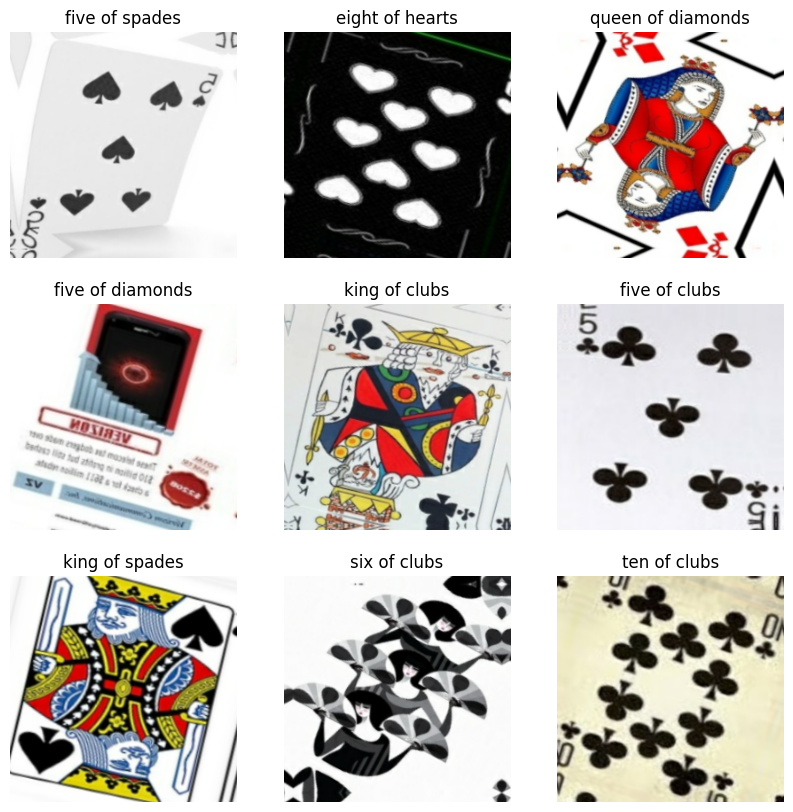

In [15]:
# Examine a sample of the training data

image_batch, label_batch = next(iter(train_ds))

from matplotlib import pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

## Building the Deep Learning Model

In [16]:
# reset the session.  Good idea if you are re-running
tf.keras.backend.clear_session()

In [17]:
# define the model
model = tf.keras.models.Sequential([
                                     tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                                     tf.keras.layers.Rescaling(1./255),
                                     tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(128, activation='relu'),
                                     tf.keras.layers.Dense(64, activation='relu'),
                                     tf.keras.layers.Dense(53, activation='softmax')])

/home/tarter/anaconda3/envs/tf-new-gpu/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
# compile the model
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# summary
model.build(input_shape=(None,IMAGE_SIZE, IMAGE_SIZE, 3))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21632)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,769,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 53)             │         3,445 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,800,117 (10.68 MB)

 Trainable params: 2,800,117 (10.68 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [20]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(buffer_size=1)
validation_ds = validation_ds.prefetch(buffer_size=1)

In [21]:
# Define callbacks
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                           patience=5,
                                                           restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                            factor=0.5,
                                                            patience=2, 
                                                            vwrbose=1)

In [22]:
# Train the model.  Print how long it took to cook.
import time
start_time = time.time()
history = model.fit(train_ds,
                    epochs = 30,
                    validation_data=validation_ds,
                    callbacks=[early_stopping_callback, reduce_lr_on_plateau])
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/30


I0000 00:00:1752503848.776835 2021821 service.cc:152] XLA service 0x7c20c80032e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752503848.776862 2021821 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-07-14 09:37:28.878400: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752503849.140764 2021821 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-14 09:37:29.700723: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_483', 8 bytes spill stores, 8 bytes spill loads

2025-07-14 09:37:29.704352: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_483', 12

  2/120 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.0156 - loss: 4.0977  

I0000 00:00:1752503858.252649 2021821 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step - accuracy: 0.0411 - loss: 3.9057 - val_accuracy: 0.2566 - val_loss: 2.6966 - learning_rate: 0.0010
Epoch 2/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - accuracy: 0.2399 - loss: 2.8470 - val_accuracy: 0.3170 - val_loss: 2.2141 - learning_rate: 0.0010
Epoch 3/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 148ms/step - accuracy: 0.3067 - loss: 2.4289 - val_accuracy: 0.3962 - val_loss: 1.9432 - learning_rate: 0.0010
Epoch 4/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.3478 - loss: 2.2686 - val_accuracy: 0.4264 - val_loss: 1.7882 - learning_rate: 0.0010
Epoch 5/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.3773 - loss: 2.1140 - val_accuracy: 0.4528 - val_loss: 1.7922 - learning_rate: 0.0010
Epoch 6/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 160ms/step - accuracy: 0.4232 - loss: 2.0099 - val_accuracy: 0.4868 - val_loss: 1.6510 - learning_rate: 0.0010
Epoch 7/30
120/120 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - accuracy: 0.4440 - loss:

## Plot Model Accuracy and Loss

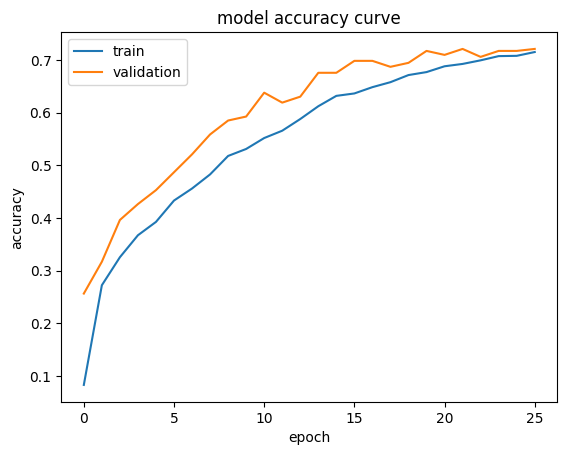

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy curve')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

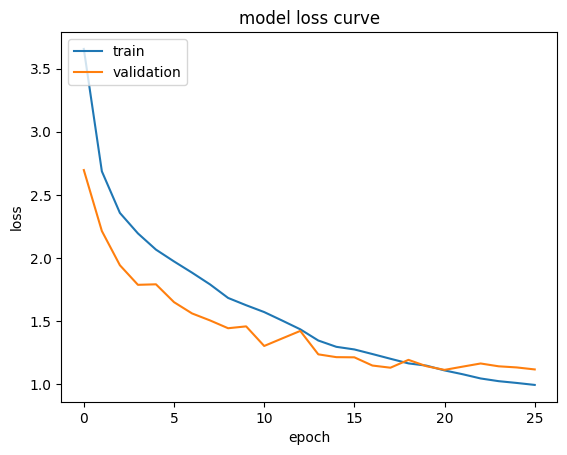

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss curve')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluate the Model

In [25]:
model.evaluate(test_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6795 - loss: 1.1665


[1.239713430404663, 0.6679245233535767]

In [26]:
# generate predictions
y_pred = model.predict(test_ds)
predicted_categories = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

# actual categories
true_categories = tf.cast(tf.concat([label for img, label in test_ds], axis=0), tf.int32)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step


In [27]:
# calculate accuracy
equality = tf.math.equal(predicted_categories, true_categories)
accuracy = tf.math.reduce_mean(tf.cast(equality, tf.float32))
accuracy

<tf.Tensor: shape=(), dtype=float32, numpy=0.6679245233535767>

In [28]:
# generate a classification report
from sklearn.metrics import classification_report
print(classification_report(true_categories,predicted_categories))

              precision    recall  f1-score   support

           0       0.57      0.80      0.67         5
           1       1.00      0.60      0.75         5
           2       0.45      1.00      0.62         5
           3       0.71      1.00      0.83         5
           4       0.57      0.80      0.67         5
           5       0.57      0.80      0.67         5
           6       0.62      1.00      0.77         5
           7       0.57      0.80      0.67         5
           8       0.75      0.60      0.67         5
           9       0.50      0.40      0.44         5
          10       0.75      0.60      0.67         5
          11       1.00      0.80      0.89         5
          12       0.50      0.60      0.55         5
          13       0.50      0.60      0.55         5
          14       0.67      0.80      0.73         5
          15       1.00      0.20      0.33         5
          16       0.75      0.60      0.67         5
          17       0.60    

In [29]:
# create confusion matrix and define function to plot it.

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(predicted_categories, true_categories)

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

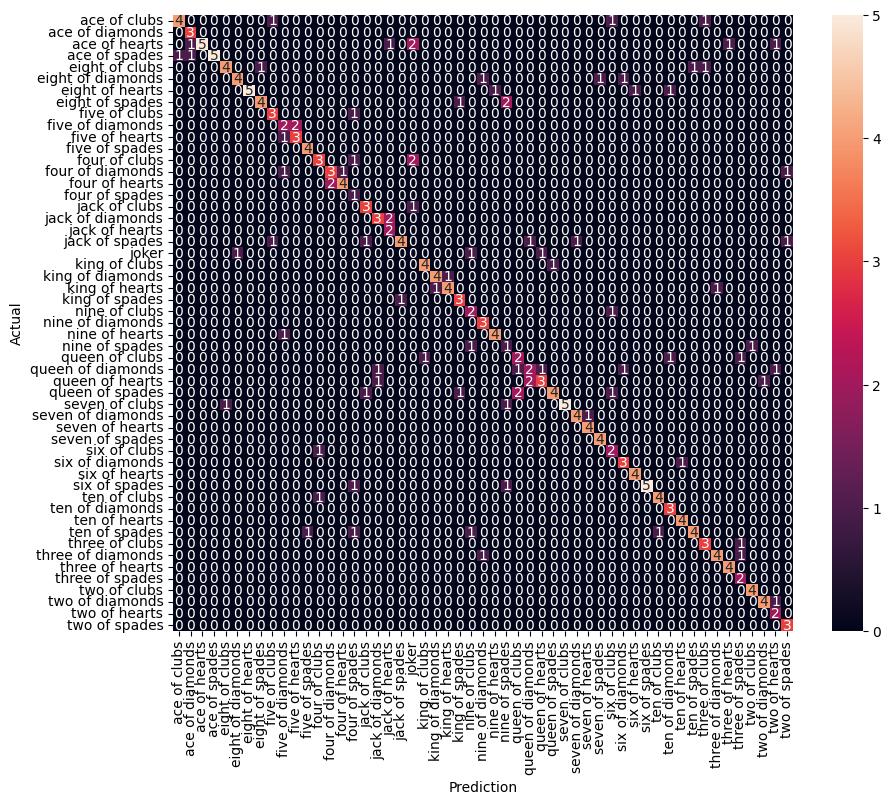

In [30]:
# plot confusion matrix
show_confusion_matrix(cm, class_names)

## Test the Model on Sample Images

In [31]:
# king of hearts
!wget --no-check-certificate \
  https://m.media-amazon.com/images/I/71d4LRYo6uL._AC_UF1000,1000_QL80_.jpg \
  -O /tmp/king_of_hearts.jpg


# ace of clubs
!wget --no-check-certificate \
  https://upload.wikimedia.org/wikipedia/commons/2/2a/Ace_of_clubs.png \
  -O /tmp/ace_of_clubs.png

--2025-07-14 09:47:43--  https://m.media-amazon.com/images/I/71d4LRYo6uL._AC_UF1000,1000_QL80_.jpg
Resolving m.media-amazon.com (m.media-amazon.com)... 3.161.233.239, 2600:9000:26ca:e600:1d:d7f6:39d4:e6e1, 2600:9000:26ca:aa00:1d:d7f6:39d4:e6e1, ...
Connecting to m.media-amazon.com (m.media-amazon.com)|3.161.233.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112997 (110K) [image/jpeg]
Saving to: ‘/tmp/king_of_hearts.jpg’

/tmp/king_of_hearts 100%[===================>] 110.35K  --.-KB/s    in 0.09s   

2025-07-14 09:47:44 (1.17 MB/s) - ‘/tmp/king_of_hearts.jpg’ saved [112997/112997]

--2025-07-14 09:47:44--  https://upload.wikimedia.org/wikipedia/commons/2/2a/Ace_of_clubs.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:860:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20976 (20K) [image/png]
Saving to: ‘/tmp/ace_

In [32]:
# Define function to classify a card image
import numpy as np
def classify(image_path):
  # load image
  image = tf.keras.utils.load_img(image_path, color_mode='rgb')
  # display the image
  display(image)
  # convert the image to an array
  input_arr = tf.keras.utils.img_to_array(image)
  # convert single image to an array
  input_arr = np.array([input_arr])
  print(f'Input array shape: {input_arr.shape}')
  # get predicted probabilities
  y_pred = model.predict(input_arr)
  # get predicted category
  predicted_category = tf.argmax(y_pred, axis=1)
  # get predicted category class name
  predicted_category_classname = class_names[int(predicted_category)]
  print(f'Predicted class: {predicted_category_classname}')

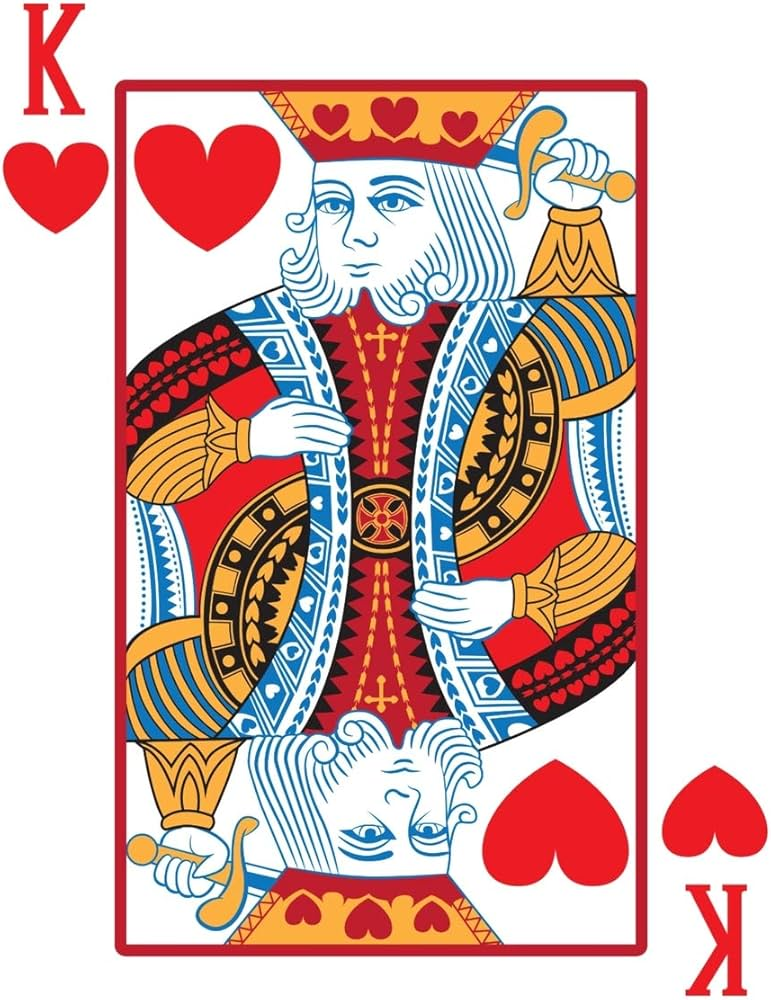

Input array shape: (1, 1000, 771, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 714ms/step
Predicted class: king of diamonds


In [33]:
# Test King of Hearts
classify('/tmp/king_of_hearts.jpg')

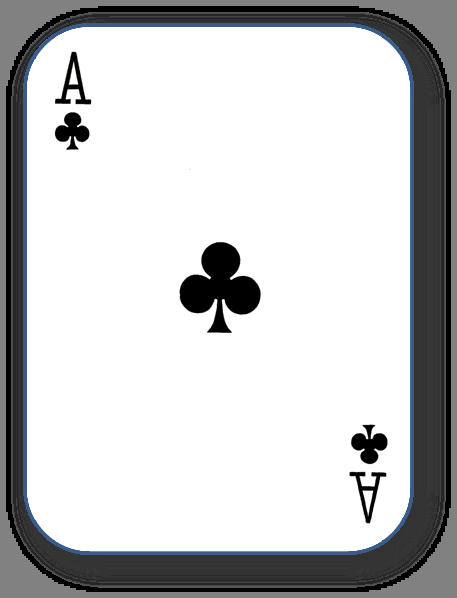

Input array shape: (1, 598, 457, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicted class: ace of clubs


In [34]:
# Test Ace of Clubs
classify('/tmp/ace_of_clubs.png')

## Save the Model

In [35]:
# Remove any previous model export
!rm -rf export

In [36]:
# Save the model locally
model.export("export/saved_model/1")

INFO:tensorflow:Assets written to: export/saved_model/1/assets


INFO:tensorflow:Assets written to: export/saved_model/1/assets


Saved artifact at 'export/saved_model/1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 53), dtype=tf.float32, name=None)
Captures:
  136483618150176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618150000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618152288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618168896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618170832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618170656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618172768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618185456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618187040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618186864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136483618